In [1]:
import numpy as np
import pandas as pd
import glob, os, sys, time
sys.path.append('/Users/shiyunqiu/')
from utils.misc import getConfigFile, readPickle, displayTime, loadHDF5,getLowestError
from   model_th.dmm import DMM
import model_th.learning as DMM_learn
import model_th.evaluate as DMM_evaluate
%matplotlib inline  
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20

/Users/shiyunqiu/miniconda3/envs/myenv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Data Loading and Transformation

In [2]:
# remove zeros and reverse the data to the correct order
df = pd.read_csv('/Users/shiyunqiu/AM231_Project/data/bitcoin_price.csv')
df = df[::-1]
df = df.Close.values[175:].reshape(-1,1)
print(df.shape)

(1585, 1)


In [3]:
# split into train and test sets
train_size = 1570
train_all, test_all = df[:train_size, :], df[train_size:, :]
print(len(train_all), len(test_all))

(1570, 15)


In [4]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
train_all = scaler.fit_transform(train_all)
test_all = scaler.transform(test_all)

In [5]:
def generate_sample(T, start_indx, end_indx, df):
    sample = []
    idx = range(start_indx, end_indx, 1)
    for val in idx:
        piece = df[val:val+T, :]
        sample.append(piece)
    return np.array(sample), idx

In [6]:
# create dataset to pass into DKF
# Train: T=10, 1555 samples
train, train_idx = generate_sample(10, 0, 1555, train_all)

# Valid: T=10, 4 samples
valid, valid_idx = generate_sample(10, 1555, len(train_all)-11, train_all)

# # Test: T=10, 4 sample
test, test_idx = generate_sample(10, 0, len(test_all)-11, test_all)


train_dict = {}
train_dict['tensor'] = train
train_dict['mask'] = np.ones((1555, 10))

valid_dict = {}
valid_dict['tensor'] = valid
valid_dict['mask'] = np.ones((4, 10))

test_dict = {}
test_dict['tensor'] = test
test_dict['mask'] = np.ones((4, 10))

dataset = {}
dataset['dim_observations'] = 1
dataset['data_type'] = 'real'
dataset['train'] = train_dict
dataset['valid'] = valid_dict
dataset['test'] = test_dict

print 'Dimensionality of the observations: ', dataset['dim_observations']
print 'Data type of features:', dataset['data_type']
for dtype in ['train','valid','test']:
    print 'dtype: ',dtype, ' type(dataset[dtype]): ',type(dataset[dtype])
    print [(k,type(dataset[dtype][k]), dataset[dtype][k].shape) for k in dataset[dtype]]
    print '--------\n'

Dimensionality of the observations:  1
Data type of features: real
dtype:  train  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (1555, 10)), ('tensor', <type 'numpy.ndarray'>, (1555, 10, 1))]
--------

dtype:  valid  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (4, 10)), ('tensor', <type 'numpy.ndarray'>, (4, 10, 1))]
--------

dtype:  test  type(dataset[dtype]):  <type 'dict'>
[('mask', <type 'numpy.ndarray'>, (4, 10)), ('tensor', <type 'numpy.ndarray'>, (4, 10, 1))]
--------



## Parameter Tuning and Model Learning

In [7]:
# load parameter
params = readPickle('default.pkl')[0]
for k in params:
    print k, '\t',params[k]

Read  1  objects
dataset 	mm
epochs 	2000
seed 	1
init_weight 	0.1
dim_stochastic 	100
expt_name 	uid
reg_value 	0.05
reloadFile 	./NOSUCHFILE
reg_spec 	_
dim_hidden 	200
lr 	0.0008
reg_type 	l2
init_scheme 	uniform
optimizer 	adam
use_generative_prior 	approx
maxout_stride 	4
batch_size 	20
savedir 	./chkpt
forget_bias 	-5.0
inference_model 	R
emission_layers 	2
savefreq 	10
rnn_cell 	lstm
rnn_size 	600
paramFile 	./NOSUCHFILE
nonlinearity 	relu
rnn_dropout 	0.1
transition_layers 	2
anneal_rate 	2.0
debug 	False
validate_only 	False
transition_type 	mlp
unique_id 	DMM_lr-0_0008-dh-200-ds-100-nl-relu-bs-20-ep-2000-rs-600-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid
leaky_param 	0.0


In [8]:
# modify parameters
params['data_type'] = dataset['data_type']
params['dim_observations'] = dataset['dim_observations']

#T Change some of the default parameters and the unique ID
params['dim_stochastic'] = 4
params['dim_hidden']     = 4
params['rnn_size']       = 64
params['epochs']         = 200
params['batch_size']     = 100
params['lr'] = 0.001

params['unique_id'] = params['unique_id'].replace('ds-100','ds-4').replace('dh-200','dh-4').replace('rs-600','rs-64')
params['unique_id'] = params['unique_id'].replace('ep-2000','ep-200').replace('bs-20','bs-200')
params['unique_id'] = params['unique_id'].replace('lr-0_0008','lr-0_001')

# Create a temporary directory to save checkpoints
params['savedir']   = params['savedir']+'-ipython/'
os.system('mkdir -p '+params['savedir'])

# Specify the file where `params` corresponding for this choice of model and data will be saved
pfile= params['savedir']+'/'+params['unique_id']+'-config.pkl'

print 'Checkpoint prefix: ', pfile

Checkpoint prefix:  ./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl


In [9]:
# build dmm
dmm  = DMM(params, paramFile = pfile)

	<<Sampling biases for LSTM from exponential distribution>>
	<<Nparameters: 34122>>
	<<WARNING: lr will not differentiated with respect to>>
	<<WARNING: anneal will not differentiated with respect to>>
	<<WARNING: update_ctr will not differentiated with respect to>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.1>>
	<<In _LSTM_RNN_layer with dropout 0.1000>>
	<<Modifying : [q_W_input_0,q_b_input_0,W_lstm_r,b_lstm_r,U_lstm_r,q_W_st,q_b_st,q_W_mu,q_b_mu,q_W_cov,q_b_cov,p_trans_W_0,p_trans_b_0,p_trans_W_1,p_trans_b_1,p_trans_W_mu,p_trans_b_mu,p_trans_W_cov,p_trans_b_cov,p_emis_W_0,p_emis_b_0,p_emis_W_1,p_emis_b_1,p_emis_W_out,p_emis_b_out]>>
<< Reg:(l2) Reg. Val:(0.05) Reg. Spec.:(_)>>
<<<<<< Adding l2 regularization for q_W_input_0 >>>>>>
<<<<<< Adding l2 regularization for q_b_input_0 >>>>>>
<<<<<< Adding l2 regularization for W_lstm_r >>>>>>
<<<<<< Adding l2 regularization for b_lstm_r >>>>>>
<<<<<< Adding l2 regularization for U_lstm_r >>>>>>
<<<<<< Adding l2 re

In [10]:
# parameter estimation
# savef specifies the prefix for the checkpoints - we'll use the same save directory as before 
savef    = os.path.join(params['savedir'],params['unique_id'])
savedata = DMM_learn.learn(dmm, dataset['train'], epoch_start =0 ,
                                epoch_end = params['epochs'],
                                batch_size = params['batch_size'],
                                savefreq   = params['savefreq'],
                                savefile   = savef,
                                dataset_eval=dataset['valid'],
                                shuffle    = True )

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [1555   10    1],[1555   10]>>
	<<Bnum: 0, Batch Bound: 0.9626, |w|: 29.2962, |dw|: 1.0000, |w_opt|: 0.0000>>
	<<-veCLL:961.6465, KL:90.8593, anneal:0.0100>>
	<<Bnum: 10, Batch Bound: 0.9815, |w|: 28.8086, |dw|: 1.0000, |w_opt|: 0.6336>>
	<<-veCLL:957.3844, KL:24.0676, anneal:1.0000>>
	<<(Ep 0) Bound: 0.9935 [Took 0.5551 seconds] >>
	<<Saving at epoch 0>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP0-params) 
		 opt (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP0-optParams) weights>>
	<<Original dim: [1555   10    1],[1555   10]>>
	<<New dim: [ 4 10  1],[ 4 10]>>
	<<(Evaluate) Validation Bound: 1.0655 [Took 0.0040 seconds]>>
	<<Original dim: [ 4 10  1],[ 4 10]>>
	<<New dim: [1555   10    1],[1555   10]>>
	<<Bnum: 0, Batch Bound: 0.9692, |w|: 28.5565, |dw|: 1.0000, |w_

	<<Bnum: 10, Batch Bound: -0.8437, |w|: 25.0706, |dw|: 1.0000, |w_opt|: 0.2097>>
	<<-veCLL:-1263.1697, KL:419.4377, anneal:1.0000>>
	<<(Ep 21) Bound: -0.8696 [Took 0.5198 seconds] >>
	<<Bnum: 0, Batch Bound: -0.8952, |w|: 25.1304, |dw|: 1.0000, |w_opt|: 0.2050>>
	<<-veCLL:-1390.9084, KL:495.7496, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.0561, |w|: 25.1957, |dw|: 1.0000, |w_opt|: 0.2567>>
	<<-veCLL:-1529.3373, KL:473.2153, anneal:1.0000>>
	<<(Ep 22) Bound: -0.9358 [Took 0.5227 seconds] >>
	<<Bnum: 0, Batch Bound: -0.9724, |w|: 25.2236, |dw|: 1.0000, |w_opt|: 0.1782>>
	<<-veCLL:-1450.9983, KL:478.5714, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.0710, |w|: 25.2611, |dw|: 1.0000, |w_opt|: 0.1808>>
	<<-veCLL:-1467.6991, KL:396.6513, anneal:1.0000>>
	<<(Ep 23) Bound: -0.9323 [Took 0.5633 seconds] >>
	<<Bnum: 0, Batch Bound: -1.1420, |w|: 25.2903, |dw|: 1.0000, |w_opt|: 0.1830>>
	<<-veCLL:-1667.2611, KL:525.2518, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.9220, |w|: 25.3238, |dw|: 1.0

	<<Bnum: 10, Batch Bound: -0.9688, |w|: 26.0153, |dw|: 1.0000, |w_opt|: 0.3730>>
	<<-veCLL:-1427.3314, KL:458.5254, anneal:1.0000>>
	<<(Ep 44) Bound: -1.1128 [Took 0.4946 seconds] >>
	<<Bnum: 0, Batch Bound: -0.6663, |w|: 26.0416, |dw|: 1.0000, |w_opt|: 0.3791>>
	<<-veCLL:-1126.2415, KL:459.9688, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.1794, |w|: 26.0397, |dw|: 1.0000, |w_opt|: 0.4225>>
	<<-veCLL:-1575.6622, KL:396.2608, anneal:1.0000>>
	<<(Ep 45) Bound: -1.0972 [Took 0.5920 seconds] >>
	<<Bnum: 0, Batch Bound: -1.2192, |w|: 26.0572, |dw|: 1.0000, |w_opt|: 0.3786>>
	<<-veCLL:-1650.5843, KL:431.3344, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.1270, |w|: 26.0740, |dw|: 1.0000, |w_opt|: 0.4226>>
	<<-veCLL:-1696.2914, KL:569.3354, anneal:1.0000>>
	<<(Ep 46) Bound: -1.2196 [Took 0.5790 seconds] >>
	<<Bnum: 0, Batch Bound: -1.1624, |w|: 26.0762, |dw|: 1.0000, |w_opt|: 0.4607>>
	<<-veCLL:-1679.5898, KL:517.2114, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.1512, |w|: 26.0931, |dw|: 1.0

	<<Bnum: 10, Batch Bound: -1.1361, |w|: 26.3099, |dw|: 1.0000, |w_opt|: 0.6523>>
	<<-veCLL:-1612.1399, KL:475.9930, anneal:1.0000>>
	<<(Ep 67) Bound: -1.1807 [Took 0.5140 seconds] >>
	<<Bnum: 0, Batch Bound: -1.4292, |w|: 26.3112, |dw|: 1.0000, |w_opt|: 0.6139>>
	<<-veCLL:-1908.0898, KL:478.9084, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.3321, |w|: 26.3139, |dw|: 1.0000, |w_opt|: 0.6121>>
	<<-veCLL:-1795.3102, KL:463.2530, anneal:1.0000>>
	<<(Ep 68) Bound: -1.3494 [Took 0.5225 seconds] >>
	<<Bnum: 0, Batch Bound: -1.1446, |w|: 26.3163, |dw|: 1.0000, |w_opt|: 0.5690>>
	<<-veCLL:-1601.1506, KL:456.5113, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.4161, |w|: 26.3223, |dw|: 1.0000, |w_opt|: 0.5737>>
	<<-veCLL:-1830.6328, KL:414.5692, anneal:1.0000>>
	<<(Ep 69) Bound: -1.3369 [Took 0.5768 seconds] >>
	<<Bnum: 0, Batch Bound: -1.3690, |w|: 26.3241, |dw|: 1.0000, |w_opt|: 0.5616>>
	<<-veCLL:-1796.0697, KL:427.0754, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.2448, |w|: 26.3356, |dw|: 1.0

	<<Bnum: 10, Batch Bound: -1.3584, |w|: 26.5470, |dw|: 1.0000, |w_opt|: 0.6782>>
	<<-veCLL:-1804.2283, KL:445.8773, anneal:1.0000>>
	<<(Ep 90) Bound: -1.4700 [Took 0.6066 seconds] >>
	<<Saving at epoch 90>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP90-params) 
		 opt (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP90-optParams) weights>>
	<<Original dim: [1555   10    1],[1555   10]>>
	<<New dim: [ 4 10  1],[ 4 10]>>
	<<(Evaluate) Validation Bound: 2.3908 [Took 0.0036 seconds]>>
	<<Original dim: [ 4 10  1],[ 4 10]>>
	<<New dim: [1555   10    1],[1555   10]>>
	<<Bnum: 0, Batch Bound: -1.3563, |w|: 26.5520, |dw|: 1.0000, |w_opt|: 0.6834>>
	<<-veCLL:-1838.9083, KL:482.6038, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5651, |w|: 26.5588, |dw|: 1.0000, |w_opt|: 0.6977>>
	<<-veCLL:-2007.6554, KL:442.5613, anneal:1.00

	<<Bnum: 10, Batch Bound: -1.5543, |w|: 26.7515, |dw|: 1.0000, |w_opt|: 0.7732>>
	<<-veCLL:-2080.8802, KL:526.6212, anneal:1.0000>>
	<<(Ep 111) Bound: -1.5274 [Took 0.5534 seconds] >>
	<<Bnum: 0, Batch Bound: -1.3618, |w|: 26.7440, |dw|: 1.0000, |w_opt|: 0.7687>>
	<<-veCLL:-1799.8939, KL:438.0648, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.7224, |w|: 26.7720, |dw|: 1.0000, |w_opt|: 0.8148>>
	<<-veCLL:-1375.1287, KL:652.7713, anneal:1.0000>>
	<<(Ep 112) Bound: -0.0531 [Took 0.5389 seconds] >>
	<<Bnum: 0, Batch Bound: 4.2814, |w|: 26.7834, |dw|: 1.0000, |w_opt|: 0.7699>>
	<<-veCLL:3412.1022, KL:869.3000, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -0.5058, |w|: 26.7706, |dw|: 1.0000, |w_opt|: 0.7690>>
	<<-veCLL:-1302.5470, KL:796.7719, anneal:1.0000>>
	<<(Ep 113) Bound: 0.3219 [Took 0.5394 seconds] >>
	<<Bnum: 0, Batch Bound: -1.1631, |w|: 26.7424, |dw|: 1.0000, |w_opt|: 0.7989>>
	<<-veCLL:-1679.2693, KL:516.1931, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.2537, |w|: 26.6959, |dw|: 1.0

	<<Bnum: 0, Batch Bound: -1.4402, |w|: 26.8996, |dw|: 1.0000, |w_opt|: 0.8331>>
	<<-veCLL:-1982.1167, KL:541.8794, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5825, |w|: 26.8780, |dw|: 1.0000, |w_opt|: 0.8330>>
	<<-veCLL:-2002.2942, KL:419.8360, anneal:1.0000>>
	<<(Ep 134) Bound: -1.5598 [Took 0.6349 seconds] >>
	<<Bnum: 0, Batch Bound: -1.5950, |w|: 26.8815, |dw|: 1.0000, |w_opt|: 0.8383>>
	<<-veCLL:-2032.4692, KL:437.5114, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.4755, |w|: 26.9114, |dw|: 1.0000, |w_opt|: 0.8567>>
	<<-veCLL:-2020.6414, KL:545.1028, anneal:1.0000>>
	<<(Ep 135) Bound: -1.5650 [Took 0.6292 seconds] >>
	<<Bnum: 0, Batch Bound: -1.6828, |w|: 26.9227, |dw|: 1.0000, |w_opt|: 0.8331>>
	<<-veCLL:-2227.5065, KL:544.7298, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.6271, |w|: 26.9392, |dw|: 1.0000, |w_opt|: 0.8565>>
	<<-veCLL:-2112.3552, KL:485.2800, anneal:1.0000>>
	<<(Ep 136) Bound: -1.5762 [Took 0.6720 seconds] >>
	<<Bnum: 0, Batch Bound: -1.5792, |w|: 26.9503, |dw|: 1

	<<Bnum: 0, Batch Bound: -1.5763, |w|: 27.0243, |dw|: 1.0000, |w_opt|: 0.8911>>
	<<-veCLL:-2100.7694, KL:524.4511, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.7093, |w|: 27.0305, |dw|: 1.0000, |w_opt|: 0.8786>>
	<<-veCLL:-2260.3716, KL:551.1091, anneal:1.0000>>
	<<(Ep 157) Bound: -1.6503 [Took 0.6308 seconds] >>
	<<Bnum: 0, Batch Bound: -1.7887, |w|: 27.0385, |dw|: 1.0000, |w_opt|: 0.8948>>
	<<-veCLL:-2304.9467, KL:516.2670, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.8115, |w|: 27.0380, |dw|: 1.0000, |w_opt|: 0.8803>>
	<<-veCLL:-2307.9842, KL:496.4791, anneal:1.0000>>
	<<(Ep 158) Bound: -1.6831 [Took 0.5810 seconds] >>
	<<Bnum: 0, Batch Bound: -1.8954, |w|: 27.0373, |dw|: 1.0000, |w_opt|: 0.8811>>
	<<-veCLL:-2388.0810, KL:492.7265, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.8424, |w|: 27.0407, |dw|: 1.0000, |w_opt|: 0.8951>>
	<<-veCLL:-2311.8042, KL:469.4509, anneal:1.0000>>
	<<(Ep 159) Bound: -1.6817 [Took 0.6004 seconds] >>
	<<Bnum: 0, Batch Bound: -1.3920, |w|: 27.0449, |dw|: 1

	<<Bnum: 10, Batch Bound: -1.7220, |w|: 27.1484, |dw|: 1.0000, |w_opt|: 0.9154>>
	<<-veCLL:-2212.1576, KL:490.1725, anneal:1.0000>>
	<<(Ep 180) Bound: -1.7043 [Took 0.5478 seconds] >>
	<<Saving at epoch 180>>
	<<Saved model (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP180-params) 
		 opt (./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP180-optParams) weights>>
	<<Original dim: [1555   10    1],[1555   10]>>
	<<New dim: [ 4 10  1],[ 4 10]>>
	<<(Evaluate) Validation Bound: 2.2418 [Took 0.0037 seconds]>>
	<<Original dim: [ 4 10  1],[ 4 10]>>
	<<New dim: [1555   10    1],[1555   10]>>
	<<Bnum: 0, Batch Bound: -1.5254, |w|: 27.1483, |dw|: 1.0000, |w_opt|: 0.9198>>
	<<-veCLL:-2090.6975, KL:565.2805, anneal:1.0000>>
	<<Bnum: 10, Batch Bound: -1.5734, |w|: 27.1472, |dw|: 1.0000, |w_opt|: 0.9176>>
	<<-veCLL:-2090.2974, KL:516.9236, anneal:

## Performance Evaluation

In [11]:
#Lets look at the statistics saved at epoch 190
stats = loadHDF5('./chkpt-ipython/DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP190-stats.h5')
print [(k,stats[k].shape) for k in stats.keys()]

[(u'valid_bound', (20, 2)), (u'train_bound', (191, 2))]


Text(0,0.5,'Lower Bound on $\\log p(x)$')

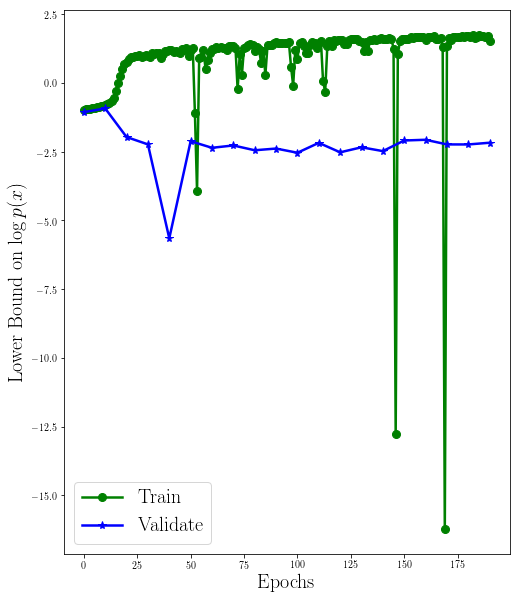

In [12]:
# evaluation
plt.figure(figsize=(8,10))
plt.plot(stats['train_bound'][:,0],-stats['train_bound'][:,1],'-o',color='g',label='Train')
plt.plot(stats['valid_bound'][:,0],-stats['valid_bound'][:,1],'-*',color='b',label='Validate')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Lower Bound on $\log p(x)$')

In [13]:
# Reload the best DMM based on the validation error
epochMin, valMin, idxMin = getLowestError(savedata['valid_bound'])
reloadFile= pfile.replace('-config.pkl','')+'-EP'+str(int(epochMin))+'-params.npz'

print 'Loading from : ',reloadFile
params['validate_only']          = True
dmm_best                         = DMM(params, paramFile = pfile, reloadFile = reloadFile)

Loading from :  ./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP10-params.npz
	<<Reloading Model>>
	<<Loading structure (./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-config.pkl) and model (./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP10-params.npz) / opt (./chkpt-ipython//DMM_lr-0_001-dh-4-ds-4-nl-relu-bs-200-ep-200-rs-64-rd-0_1-infm-R-tl-2-el-2-ar-2_0-use_p-approx-rc-lstm-uid-EP10-optParams.npz) weights>>
Adding/Modifying loaded parameters:  validate_only  to  True
	<<Nparameters: 34125>>
	<<Anneal = 1 in 2.0 param. updates>>
	<<Building with RNN dropout:0.0>>
	<<In _LSTM_RNN_layer with dropout 0.0000>>


models/__init__.py:201: UserWarning: lr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: anneal found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")
models/__init__.py:201: UserWarning: update_ctr found in npWeights. No action taken
  warnings.warn(name+" found in npWeights. No action taken")


	<<Completed DMM setup>>
	<<_buildModel took : 24.2213 seconds>>


## Prediction and Test Performance

In [14]:
test_bound = DMM_evaluate.evaluateBound(dmm_best, dataset['test'], batch_size = params['batch_size'])
print("Test bound", test_bound)
print("Validation bound", stats['valid_bound'][-1,1])
print("Train bound", stats['train_bound'][-1,1])

	<<Original dim: [3 5 1],[3 5]>>
	<<New dim: [ 4 10  1],[ 4 10]>>
	<<(Evaluate) Validation Bound: 0.8855 [Took 0.0060 seconds]>>
('Test bound', 0.8855314013254689)
('Validation bound', 2.1789421696302718)
('Train bound', -1.5378885219576186)


In [15]:
train_pred, _ =DMM_evaluate.reconstruct(dmm_best, dataset['train'])

In [16]:
valid_pred, _ =DMM_evaluate.reconstruct(dmm_best, dataset['valid'])

In [17]:
test_pred, _ = DMM_evaluate.reconstruct(dmm_best, dataset['test'])

In [21]:
def evaluate_rmse(prediction, dataset, idx):
    error_sum = 0
    for i in range(len(prediction)):
        error_sum += (dataset[idx[i]+10][0]-prediction[i][-1][0])**2
    error_sum /= (i+1)
    return np.sqrt(error_sum)

In [22]:
print("RMSE before Reversing MinMaxScaler")
print("Training RMSE:", evaluate_rmse(train_pred, train_all, train_idx))
print("Validation RMSE:", evaluate_rmse(valid_pred, train_all, valid_idx))
print("Test RMSE:", evaluate_rmse(test_pred, test_all, test_idx))

RMSE before Reversing MinMaxScaler
('Training RMSE:', 0.15446042796076756)
('Validation RMSE:', 0.38167453189237854)
('Test RMSE:', 0.48172140591904034)


In [23]:
def evaluate_rmse_inv(prediction, dataset, idx):
    error_sum = 0
    for i in range(len(prediction)):
        error_sum += (scaler.inverse_transform(dataset[idx[i]+10][0])-\
                      scaler.inverse_transform(prediction[i][-1][0]))**2
    error_sum /= (i+1)
    return np.sqrt(error_sum)

In [24]:
print("RMSE Original Scale")
print("Training RMSE:", evaluate_rmse_inv(train_pred, train_all, train_idx))
print("Validation RMSE:", evaluate_rmse_inv(valid_pred, train_all, valid_idx))
print("Test RMSE:", evaluate_rmse_inv(test_pred, test_all, test_idx))

RMSE Original Scale
('Training RMSE:', array([[2984.6064128]]))
('Validation RMSE:', array([[7375.0168281]]))
('Test RMSE:', array([[9308.20156508]]))
